In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
import sys
import multiprocessing
from dynesty import NestedSampler
from dynesty import plotting as dyplot
import multiprocessing
from psiam_tied_dv_map_utils import cum_A_t_fn, cum_E_t_fn

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
df_1 = df_1[ df_1['timed_fix'] > df_1['intended_fix'] ]

In [6]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [7]:
vp_sample = vp.sample(int(1e6))[0]

In [8]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor
# t_A_aff = 0.05 # NOTE: TEMP, to test if negative afferent delay is causing VBMC to not converge

In [9]:
t_A_aff

np.float64(-0.22650705795454615)

# VBMC

## loglike fn

In [10]:
T_censor = 0.21

In [11]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    rt = timed_fix
    t_stim = intended_fix
    
    K_max = 10

    # LEFT censoring
    if rt - t_stim < T_censor:
        cum_proactive = cum_A_t_fn(T_censor - t_A_aff, V_A, theta_A)
        cum_reactive = cum_E_t_fn(T_censor - t_E_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
        likelihood = cum_proactive + cum_reactive - cum_proactive * cum_reactive
    # RIGHT CENSORING
    # if rt - t_stim > T_censor:
    #     cum_proactive = 1 - cum_A_t_fn(T_censor - t_A_aff, V_A, theta_A)
    #     cum_reactive = 1 - cum_E_t_fn(T_censor - t_E_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    #     likelihood = cum_proactive + cum_reactive - cum_proactive * cum_reactive
    else:
        if choice == 3:
            likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                        theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]
        elif choice == 2:
            likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params


    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L)\
                                       for _, row in df_1.iterrows() if (row['timed_fix'] > row['intended_fix']) \
                                        and (row['response_poke'] in [2,3]))

    loglike = np.sum(all_loglike)
    return loglike

In [12]:

def dynesty_psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params
    
    # Filter DataFrame rows first
    filtered_rows = df_1.loc[
        (df_1['timed_fix'] > df_1['intended_fix']) &
        (df_1['response_poke'].isin([2, 3]))
    ]
    
    # Prepare arguments for each row
    # We'll map over just the row data. The other parameters are closed over
    # from the outer scope.
    row_data = [row for _, row in filtered_rows.iterrows()]

    # Use multiprocessing Pool
    # You can adjust processes=30 to however many processes you need
    all_loglike = np.array([compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L) for row in row_data])

    # Sum the log-likelihoods
    loglike = np.sum(all_loglike)

    # If loglike is inf or -inf or nan, return log(1e-50)
    if np.isnan(loglike) or np.isinf(loglike):
        return np.log(1e-50)
    else:
        return loglike


## Bounds

In [13]:
# rate_lambda_bounds = [0.01, 0.2]
# theta_E_bounds = [30, 60]
# T_0_bounds = [0.1*(1e-3), 1*(1e-3)]


# t_E_aff_bounds = [0.001, 0.1]
# Z_E_bounds = [-10, 10]
# L_bounds = [0.1, 1.99]


rate_lambda_bounds = [0.04, 0.1]
T_0_bounds = [0.20*(1e-3), 0.30*(1e-3)]
theta_E_bounds = [45, 65]

t_E_aff_bounds = [0.01, 0.05]
Z_E_bounds = [-5, 5]
L_bounds = [0.1, 0.9]
# ---
# rate_lambda_plausible_bounds =  [0.05, 0.09]
# T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
# theta_E_plausible_bounds = [40, 55]

# t_E_aff_plausible_bounds = [0.01, 0.05]
# Z_E_plausible_bounds = [-5, 5]
# L_plausible_bounds = [0.5, 1.5]

rate_lambda_plausible_bounds =  [0.07, 0.09]
T_0_plausible_bounds = [0.22*(1e-3), 0.29*(1e-3)]
theta_E_plausible_bounds = [50, 60]

t_E_aff_plausible_bounds = [0.015, 0.03]
Z_E_plausible_bounds = [-2, 2]
L_plausible_bounds = [0.5, 0.8]


## prior

In [14]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


In [15]:
def trapezoidal_transform(u, a, b, c, d):
    """
    Maps a uniform random variable u ~ Uniform[0, 1] to a trapezoidal prior distribution.
    """
    area_left = (b - a) / 2
    area_middle = c - b
    area_right = (d - c) / 2
    total_area = area_left + area_middle + area_right

    # Normalize u to the total area
    u_scaled = u * total_area

    if u_scaled <= area_left:
        # Left ramp
        return a + (2 * u_scaled * (b - a))**0.5
    elif u_scaled <= area_left + area_middle:
        # Flat top
        return b + (u_scaled - area_left)
    else:
        # Right ramp
        return d - (2 * (total_area - u_scaled) * (d - c))**0.5

def prior_transform(u):
    """
    Transform a unit cube sample (u ~ Uniform[0,1]) to the parameter space using trapezoidal priors.
    """
    priors = np.zeros_like(u)

    # Map each parameter using the trapezoidal transform
    priors[0] = trapezoidal_transform(u[0], rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], 
                                       rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    priors[1] = trapezoidal_transform(u[1], T_0_bounds[0], T_0_plausible_bounds[0], 
                                       T_0_plausible_bounds[1], T_0_bounds[1])
    priors[2] = trapezoidal_transform(u[2], theta_E_bounds[0], theta_E_plausible_bounds[0], 
                                       theta_E_plausible_bounds[1], theta_E_bounds[1])
    priors[3] = trapezoidal_transform(u[3], t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], 
                                       t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    priors[4] = trapezoidal_transform(u[4], Z_E_bounds[0], Z_E_plausible_bounds[0], 
                                       Z_E_plausible_bounds[1], Z_E_bounds[1])
    priors[5] = trapezoidal_transform(u[5], L_bounds[0], L_plausible_bounds[0], 
                                       L_plausible_bounds[1], L_bounds[1])

    return priors


## prior + loglike

In [16]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [17]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -32574.84      2464.83          inf        2        inf     start warm-up
     1         15      -30981.11       269.80     23799.50        2        inf     
     2         20      -30055.51       200.75       196.24        2   6.43e+03     
     3         25      -29492.78       230.38        66.65        2   3.55e+03     
     4         30      -29542.06       232.08       146.45        2   2.93e+03     
     5         35      -29392.37       296.21     11108.79        2   1.53e+05     
     6         40      -29106.12       182.98       297.92        2   5.62e+03     
     7         45      -28963.90       303.7

In [85]:
vbmc.save('NOT_working_ONLY_TIED_params_led_off_data_RIGHT_CENSOR.pkl', overwrite=True)

In [10]:
with open('NOT_working_ONLY_TIED_params_led_off_data_LEFT_CENSOR.pkl', 'rb') as f:
    vp = pickle.load(f)

In [11]:
vp = vp.vp

## corner plots

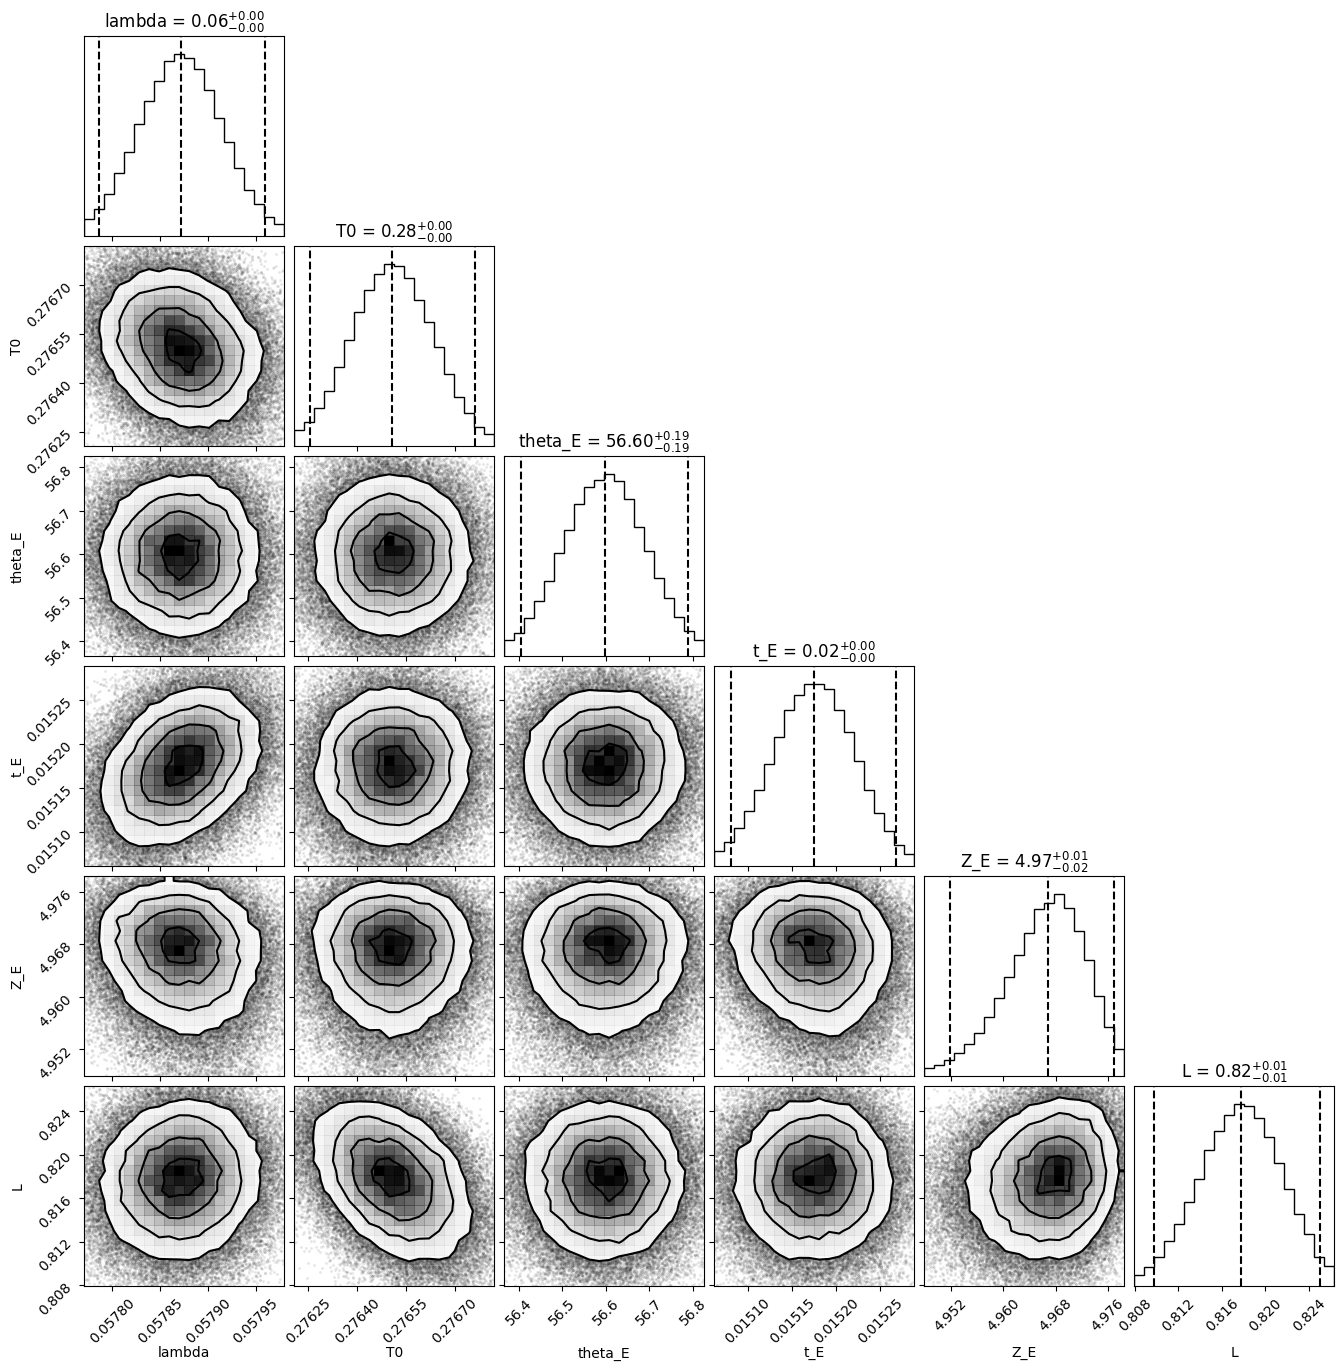

In [19]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# diagnose

## simulate data

In [20]:
lambda_mean = np.mean(vp_samples[:,0])
T0_mean = np.mean(vp_samples[:,1]) / 1e3
theta_E_mean = np.mean(vp_samples[:,2])

t_E_aff_mean = np.mean(vp_samples[:,3])
Z_E_mean = np.mean(vp_samples[:,4])
L_mean = np.mean(vp_samples[:,5])

In [21]:
t_stim_0 = 0.2
t_stim_tau = 0.4
iter_num = 2
N_print = 3
dt = 1e-3
N_sim = 50_000

# sample intended_fix of N_sim from df_1
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)

# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
#                                 t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

In iter_num: 0, ABL: 60, ILD: 2.0, t_stim: 0.371307614763295
In iter_num: 3, ABL: 20, ILD: 4.0, t_stim: 1.02771425807092
In iter_num: 6, ABL: 20, ILD: -1.0, t_stim: 0.361411736672836
In iter_num: 9, ABL: 60, ILD: 4.0, t_stim: 0.374891777039127
In iter_num: 12, ABL: 20, ILD: -4.0, t_stim: 1.37380726169284
In iter_num: 15, ABL: 40, ILD: -16.0, t_stim: 0.915089338776312
In iter_num: 18, ABL: 60, ILD: 2.0, t_stim: 0.265858202215362
In iter_num: 21, ABL: 20, ILD: 2.0, t_stim: 0.535233838760502
In iter_num: 24, ABL: 60, ILD: -16.0, t_stim: 0.509923956659107
In iter_num: 27, ABL: 20, ILD: 1.0, t_stim: 1.08146938532256
In iter_num: 30, ABL: 40, ILD: 2.0, t_stim: 0.73394615979346
In iter_num: 33, ABL: 40, ILD: 8.0, t_stim: 0.729328643804546
In iter_num: 36, ABL: 40, ILD: -8.0, t_stim: 0.344841572460897
In iter_num: 39, ABL: 20, ILD: 16.0, t_stim: 1.2003988176699
In iter_num: 42, ABL: 60, ILD: 2.0, t_stim: 0.506649297001197
In iter_num: 45, ABL: 60, ILD: 16.0, t_stim: 0.263680631693015
In iter_n

## valid rt wrt stim

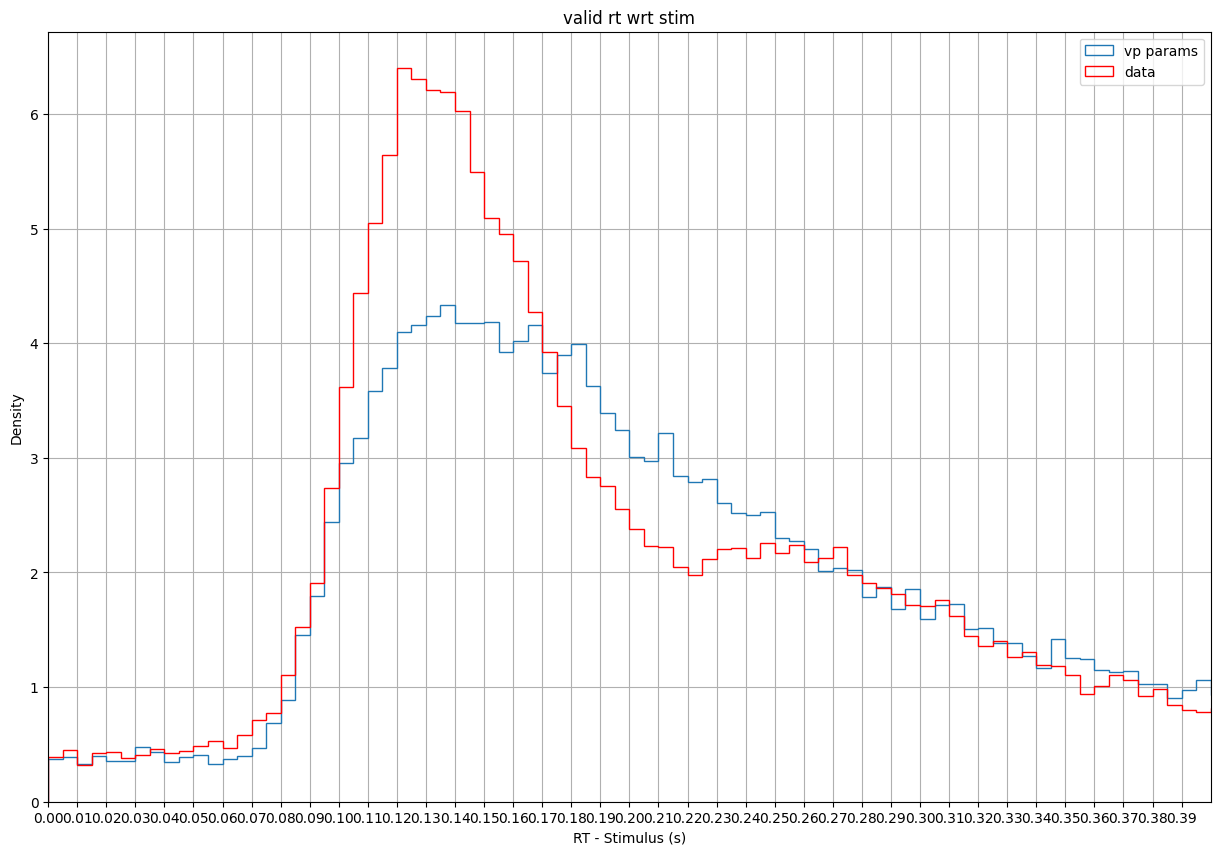

In [37]:
plt.figure(figsize=(15,10))
rt_wrt_stim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
bins = np.arange(0, 1, 0.005)
plt.hist(rt_wrt_stim, bins=bins, density=True, histtype='step', label='vp params');

data_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']
plt.hist(data_rt_wrt_stim, bins=bins, density=True, histtype='step', color='red', label='data');
plt.xlabel('RT - Stimulus (s)');    
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt stim')
# plt.xlim(-1,1)
plt.grid(True)
plt.xlim(0,0.4)
xticks = np.arange(0, 0.4, 0.01)
plt.xticks(xticks, [f'{x:.2f}' for x in xticks]);

## valid rt wrt fix

Text(0.5, 1.0, 'valid rt wrt fix')

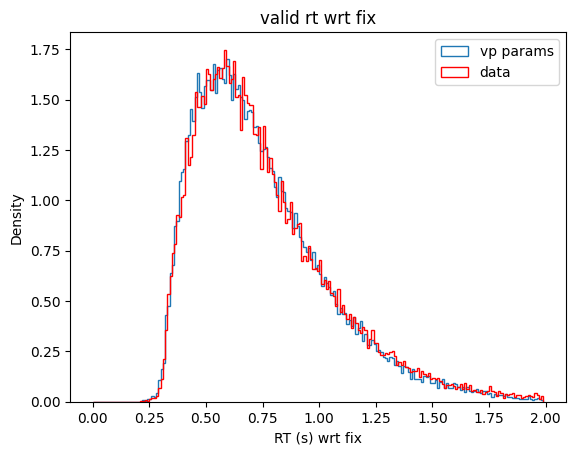

In [23]:
rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
data_rt = df_1['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(data_rt, bins=bins, density=True, histtype='step', color='red', label='data');

plt.xlabel('RT (s) wrt fix');
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt fix')


## all rt wrt fix

Text(0.5, 1.0, 'all rt inclding aborts wrt fix')

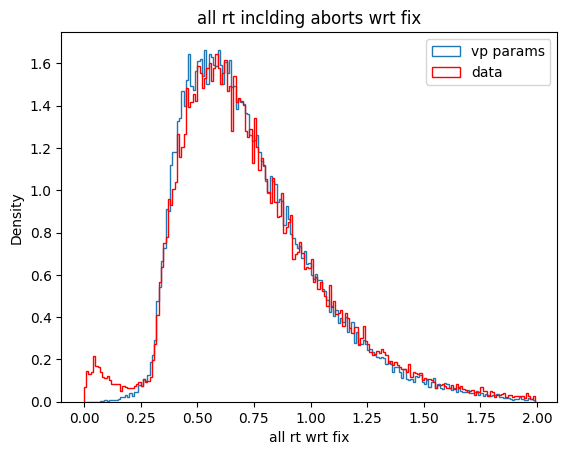

In [24]:
all_rt = [res['rt'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt inclding aborts wrt fix')

# all rt wrt fix, trunc aborts removed

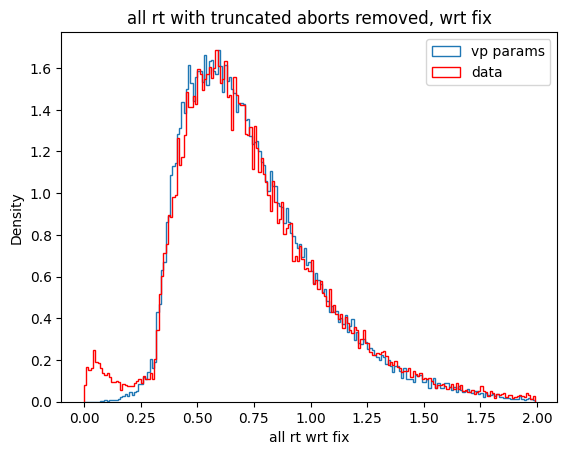

In [25]:
all_rt = [res['rt'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt fix');

## all rt wrt stim

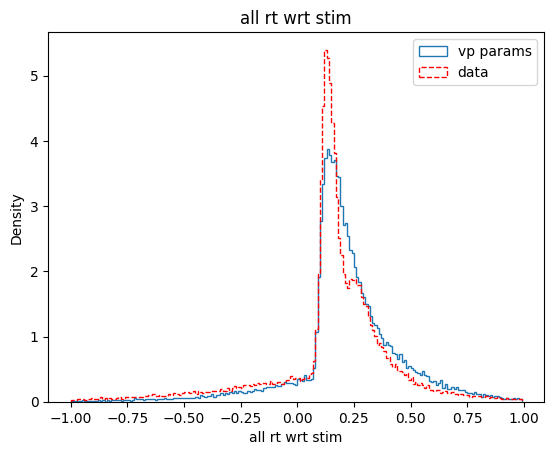

In [26]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data', ls='--');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt wrt stim');

# all rt wrt stim trunc aborts removed

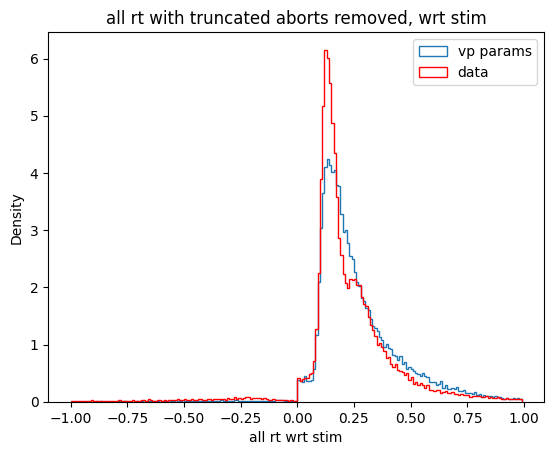

In [27]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt stim');

## psychometric

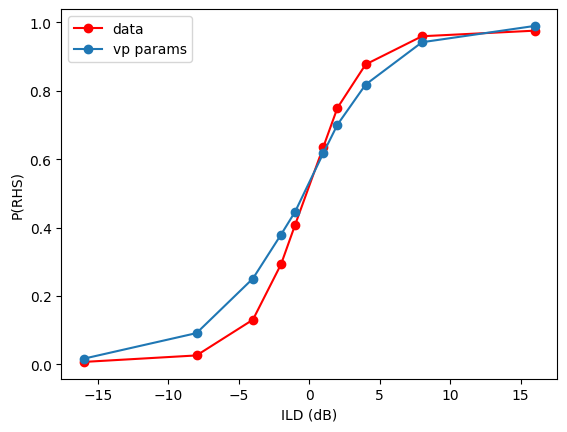

In [28]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ]
sim_results_valid_df = sim_results_valid_df.copy()

sim_results_valid_df.loc[:, 'RHS'] = (sim_results_valid_df['choice'] > 0).astype(int)
sim_grouped = sim_results_valid_df.groupby('ILD')['RHS'].mean().reset_index()

# data
data_df = df_1.copy()
data_df.loc[:, 'RHS'] = (data_df['response_poke'] == 3).astype(int)
data_grouped = data_df.groupby('ILD')['RHS'].mean().reset_index()

plt.plot(data_grouped['ILD'], data_grouped['RHS'], label='data', marker='o', color='red');
plt.plot(sim_grouped['ILD'], sim_grouped['RHS'], label='vp params', marker='o');
plt.xlabel('ILD (dB)');
plt.ylabel('P(RHS)');
plt.legend();

## tachometric

/tmp/ipykernel_601030/464138592.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()
/tmp/ipykernel_601030/464138592.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()


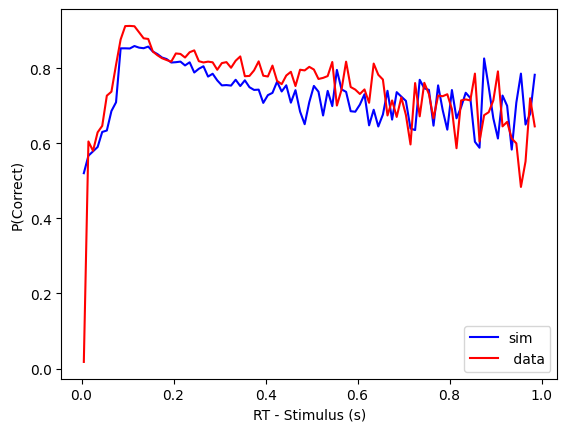

In [29]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

# sim results
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ].copy()
sim_results_valid_df.loc[:, 'correct'] = (sim_results_valid_df['choice'] * sim_results_valid_df['ILD'] > 0)
sim_results_valid_df.loc[:, 'rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

sim_results_valid_df['rt_bin'] = pd.cut(sim_results_valid_df['rt_wrt_stim'], bins=bins, right=False)
sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, sim_grouped['correct'], linestyle='-', label='sim', color='b')

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

data_df['rt_bin'] = pd.cut(data_df['rt_wrt_stim'], bins=bins, right=False)
data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, data_grouped['correct'], linestyle='-', label=' data', color='r')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('P(Correct)');
plt.legend();


# tachometric ABL wise

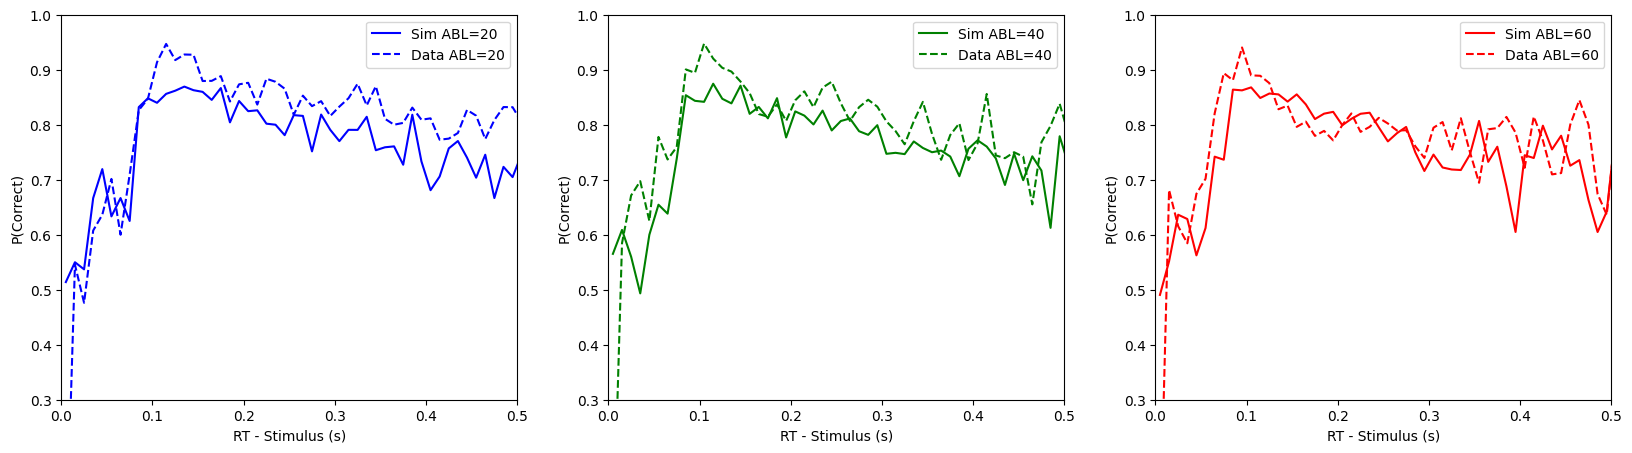

In [30]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

plt.figure(figsize=(20, 5))

ABL_values = np.sort(df_1['ABL'].unique())
colors = ['b', 'g', 'r']  # You can pick your own color scheme
a = 1
for abl_val, c in zip(ABL_values, colors):
    plt.subplot(1, len(ABL_values), a)
    # --- 1) Filter SIM dataframe for the given ABL value ---
    sim_sub = sim_results_valid_df[sim_results_valid_df['ABL'] == abl_val].copy()
    # Bin the RT values
    sim_sub['rt_bin'] = pd.cut(sim_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    sim_grouped = sim_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot SIM result (solid line)
    plt.plot(bin_centers, sim_grouped['correct'], 
            linestyle='-', 
            color=c, 
            label=f'Sim ABL={abl_val}')
    
    # --- 2) Filter DATA dataframe for the given ABL value ---
    data_sub = data_df[data_df['ABL'] == abl_val].copy()
    # Bin the RT values
    data_sub['rt_bin'] = pd.cut(data_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    data_grouped = data_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot DATA result (dashed line)
    plt.plot(bin_centers, data_grouped['correct'], 
            linestyle='--', 
            color=c, 
            label=f'Data ABL={abl_val}')

        # Cosmetics
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('P(Correct)')
    plt.ylim([0.3, 1])  # If you want to fix y-limits
    plt.xlim(0, 0.5)
    plt.legend()
    a += 1



# investigate second bump

Text(0.5, 0.98, 'Second Bump Data Distribution')

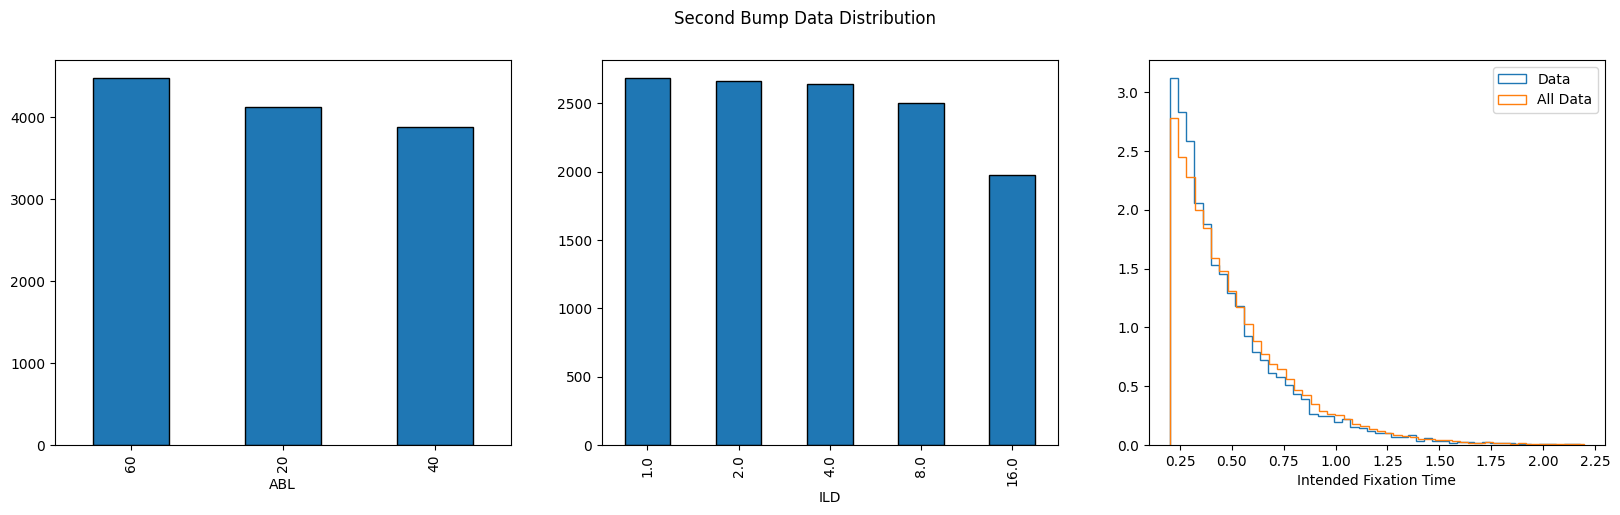

In [32]:
low_rt = 0.21
high_rt = 0.33

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='Data', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='All Data', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('Second Bump Data Distribution')

Text(0.5, 0.98, 'First Bump Data Distribution')

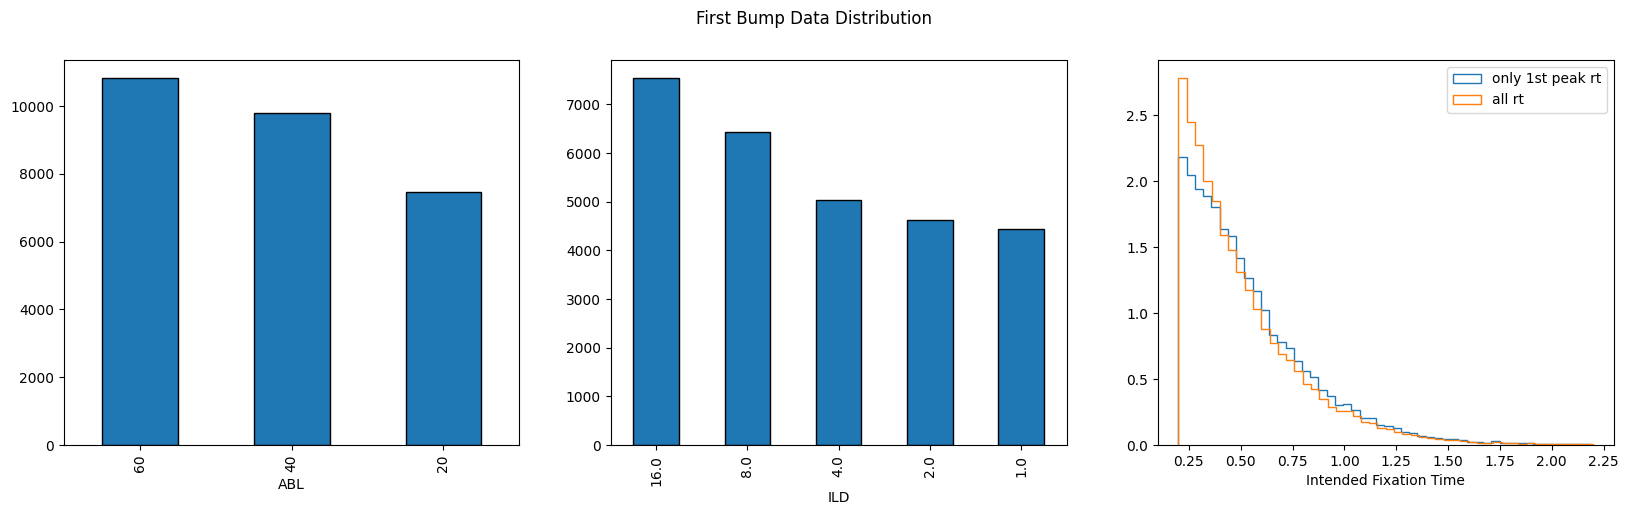

In [40]:
low_rt = 0.08
high_rt = 0.21

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='only 1st peak rt', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='all rt', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('First Bump Data Distribution')

In [ ]:
# Assuming `trial` column in df_second_bump contains integer values
# Create a list of trials minus 1
trial_minus_1 = df_second_bump['trial'] - 1

# Filter rows from df_1 where the trial column matches the values in trial_minus_1
filtered_df = og_df[og_df['trial'].isin(trial_minus_1)]

# Display the filtered dataframe
abort_event = filtered_df['abort_event']

abort_event_counts = abort_event.value_counts()
abort_event_counts.plot(kind="bar", edgecolor="black")
plt.title(f'Abort event count of trial - 1 for second bump data btn {low_rt} and {high_rt} s')

In [34]:
# Ensure the DataFrame index is reset to align with row positions
df = df.reset_index(drop=True)

# Create a mask to identify rows where the conditions are met
mask = df.apply(
    lambda row: (
        row['trial'] > 1  # Ensure trial-1 is a valid index
        and (row['trial'] - 1) in df.index  # Check trial-1 exists in the DataFrame index
        and df.iloc[int(row['trial']) - 1]['abort_event'] == 3  # Check abort_event in trial-1
        and row['ABL'] == df.iloc[int(row['trial']) - 1]['ABL']  # Match ABL with trial-1
        and row['ILD'] == df.iloc[int(row['trial']) - 1]['ILD']  # Match ILD with trial-1
        and row['success'] == 1
    ),
    axis=1
)

# Remove the rows that meet the condition
df_removed_repeats = df[~mask]


In [35]:
df_removed_repeats_led_off_valid_trials = df_removed_repeats[ (df_removed_repeats['LED_trial'] == 0) & \
                                                             (df_removed_repeats['success'] == 1) ]

In [ ]:
rt_wrt_stim_df_non_repeat = df_removed_repeats_led_off_valid_trials['timed_fix'] \
    - df_removed_repeats_led_off_valid_trials['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(rt_wrt_stim_df_non_repeat, bins=bins, density=True, histtype='step', label='data');
plt.title('valid rt wrt stim, no repeat trials')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');



# see animal wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

animals = df_1['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1

for animal in animals:
    animal_data = df_1[ df_1['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.title(f'valid rt wrt stim, Animal={animal}')
    a += 1


    

In [ ]:
except_animals = [92, 93, 98]
df_1_except = df_1[ ~df_1['animal'].isin(except_animals) ]

df_1_except_animals_rt_wrt_stim = df_1_except['timed_fix'] - df_1_except['intended_fix']
df_1_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(df_1_rt_wrt_stim, bins=bins, density=True, histtype='step', label='all', ls='--');
plt.hist(df_1_except_animals_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'removed except {except_animals}');
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.title(f'valid rt wrt stim, except {except_animals}');
plt.legend();

# df led on also?

In [ ]:
df_led_on = df [ df['LED_trial'] == 1 ]
df_led_on_valid_trials = df_led_on[ df_led_on['success'] == 1 ]
led_on_rt_wrt_stim = df_led_on_valid_trials['timed_fix'] - df_led_on_valid_trials['intended_fix']

led_off_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(led_on_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
plt.hist(led_off_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b', alpha=0.6);
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.legend();
plt.title('all animals valid rt wrt stim');

In [ ]:
# animal wise LED on

animals = df_led_on['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1
for animal in animals:
    animal_data = df_led_on_valid_trials[ df_led_on_valid_trials['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ON,  Animal={animal}')
    a += 1
    

# plot RTs as func of ABL

In [ ]:
plt.figure(figsize=(20, 5))
a = 1
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
    plt.subplot(1, len(ABL_arr), a)
    plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ABL={ABL}')
    a += 1
    


In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,30))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    for ABL in ABL_arr:
        plt.subplot(5, 3, a)

        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
        plt.xlabel('RT - Stimulus (s)');
        plt.ylabel('density')
        plt.title(f'abs ILD={ILD}')
        plt.legend();
        a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,5))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    plt.subplot(1,6, a)
    for ABL in ABL_arr:
        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ILD={ILD}')
    plt.legend();
    a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,15))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    plt.subplot(3,1, a)
    for ILD in pos_ILD:
        ILD_data = ABL_data[ (ABL_data['ILD'] == ILD) | (ABL_data['ILD'] == -ILD) ]
        ILD_rt_wrt_stim = ILD_data['timed_fix'] - ILD_data['intended_fix']
        plt.hist(ILD_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ILD={ILD}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ABL={ABL}')
    a += 1

# all animals on and off

In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']

    plt.subplot(1, len(animals), a)
    plt.hist(animal_on_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
    plt.hist(animal_off_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1



In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']
    plt.subplot(1, len(animals), a)
    # hist on - hist off
    hist_on, _ = np.histogram(animal_on_valid_rt_wrt_stim, bins=bins, density=True)
    hist_off, _ = np.histogram(animal_off_valid_rt_wrt_stim, bins=bins, density=True)

    plt.plot(bins[:-1], hist_on - hist_off, label='LED ON - LED OFF');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1

